<a href="https://colab.research.google.com/github/joe-liad/lewisham-ward-profiles/blob/main/New_Cross_Gate_Ward_Profiles_(23_Nov).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lewisham's New Ward Boundaries -- A Data Preview
==
Lewisham's ward boundaries are [set to change](https://consultation.lgbce.org.uk/node/17020) in the run-up to the 2022 elections. Unfortunately, data repositories such as the [Lewisham Observatory](https://www.observatory.lewisham.gov.uk/) will not be updated in time to reflect these changes.  

This work serves as a stop-gap measure to bridge this transition period. Can we anticipate how the new ward boundaries will change the makeup of the new wards, so that we can update our internal Ward Profile documents in preparation for the elections?

_This document was produced by the Lewisham Insight & Delivery team in November 2021 for a first internal demo._

The old & new ward boundaries
--
* The boundaries of 2 wards will stay the same (Telegraph Hill and Forest Hill) – all others will change
* 2 wards will no longer exist – New Cross and Whitefoot
* We will have 3 brand new wards – Deptford, Hither Green and New Cross Gate
* 16 wards will have 3 councillors
* 3 wards will have only 2 councillors – Bellingham, Lewisham Central and New Cross Gate
* The total number of councillors will remain the same as previously

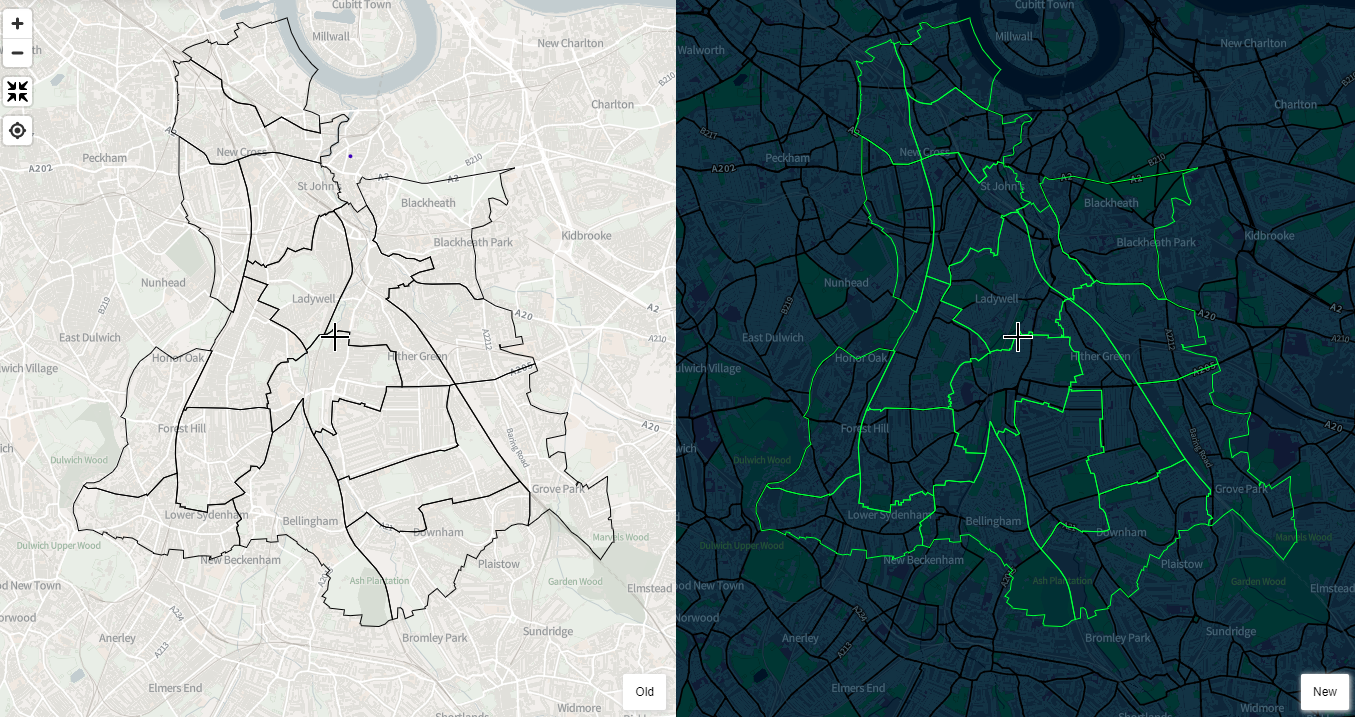

| New wards for 2022 (with 2011 OAs) | 2011 LSOA boundary mismatch |
| --- | --- |
| [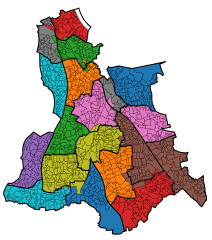](https://drive.google.com/file/d/1009XoubRQTpW5PAK1-YCVlEfljzmhSkY/view?usp=sharing)       |      [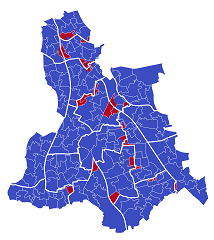](https://drive.google.com/file/d/1-OwhU785olfVDv6YxFda9T8qhXFBPg5C/view?usp=sharing) |

Statistical geographies
--
  | Area type | Lower threshold | | Upper threshold | |
  |---|---|---|---|---|
  | People | Households | People | Households | People |
  | Output Areas | 100 | 40 | 625 | 250 |
  | Lower Layer Super Output Areas | 1,000 | 400 | 3,000 | 1,200 |
  | Middle Layer Super Output Areas | 5,000 | 2,000 | 15,000 | 6,000 |

Setup
==
Hide this section for improved readability.

Environment
--

In [ ]:
# Dependencies
%%capture
!pip install geopandas mapclassify

In [ ]:
import os

import geopandas as gpd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import IPython

In [ ]:
def in_colab():
  return True if os.getenv("HOME") == "/root" else False

In [ ]:
# Google Drive access
if in_colab():
    from google.colab import drive
    drive.mount("/content/gdrive")
    project_dir = "/content/gdrive/MyDrive/WardProfiles"
else:
    project_dir = "/Volumes/GoogleDrive/My Drive/WardProfiles"

print("project_dir:", project_dir)


Mounted at /content/gdrive
project_dir: /content/gdrive/MyDrive/WardProfiles


Data
--

In [ ]:
# OA geometry
oa11 = gpd.read_file(f"{project_dir}/boundaries/oa/lbl_oa11_20m.gpkg")
lsoa11 = gpd.read_file(f"{project_dir}/boundaries/oa/lbl_lsoa11_20m.gpkg")

# Ward geometry
wd22 = gpd.read_file(f"{project_dir}/boundaries/2022_wards/lbl_wd22_proposed.gpkg")

In [ ]:
# Ward names and ward Code->Name lookup
ward_codes_names = pd.read_csv(f"{project_dir}/lookups/2022_wards/lbl_wd22_proposed.csv")
wards = ward_codes_names.WD22NM_proposed.unique().tolist()

ward_name_lookup = ward_codes_names.set_index('WD22CD_proposed').WD22NM_proposed.to_dict()

# Generic function to derive a new dataframe column from an existing one with
# the help of a lookup.
# This is a closure (it binds some variables to a generic function.)
# This way we can configure different versions for different types of source data.
def add_column_from_lookup(lookup, src_col, dst_col, drop_src_col=False):
  def add_column(d):
    t = d.copy()
    # Add derived column
    t[dst_col] = t[src_col].map(lambda v: lookup[v])
    # Drop source column?
    if drop_src_col:
      t = t.drop(columns=[src_col])
    return t
  return add_column

# Utility function to add a 'Name' column to dataframes where we have ward codes
add_ward_name = add_column_from_lookup(ward_name_lookup, 'WD22CD_proposed', 'Name', drop_src_col=True) 

In [ ]:
# Populations -- note we add a 'Name' column:

# Absolute totals:
pop_totals = add_ward_name(pd.read_csv(f"{project_dir}/population/lbl_pop_est_2020_5ybins_all_wd22.csv"))
pop_totals = pop_totals.set_index('Name')[['AllAges']].rename(columns={'AllAges': 'Total'})
pop_female_totals = add_ward_name(pd.read_csv(f"{project_dir}/population/lbl_pop_est_2020_5ybins_female_wd22.csv"))
pop_female_totals = pop_female_totals.set_index('Name')[['AllAges']].rename(columns={'AllAges': 'Total'})

# Relative share by age group and gender:
pop_age_groups = add_ward_name(pd.read_csv(f"{project_dir}/population/lbl_pop_est_2020_5ybins_all_share_wd22.csv"))
# pop_female = add_ward_name(pd.read_csv(f"{project_dir}/population/lbl_pop_est_2020_5ybins_female_share_wd22.csv"))
# pop_male = add_ward_name(pd.read_csv(f"{project_dir}/population/lbl_pop_est_2020_5ybins_male_share_wd22.csv"))

# # These already have a 'Name' column
pop_all_refs = pd.read_csv(f"{project_dir}/population/references_pop_est_2020_5ybins_all_share.csv")
# pop_female_refs = pd.read_csv(f"{project_dir}/population/references_pop_est_2020_5ybins_female_share.csv")
# pop_male_refs = pd.read_csv(f"{project_dir}/population/references_pop_est_2020_5ybins_male_share.csv")

In [ ]:
english_proficiency = add_ward_name(pd.read_csv(f"{project_dir}/languages/lbl_english_proficiency_share_coarse_wd22.csv"))
english_proficiency_refs = pd.read_csv(f"{project_dir}/languages/references_english_proficiency_share_coarse.csv")

english_proficiency_oa = oa11.merge(pd.read_csv(f"{project_dir}/languages/lbl_english_proficiency_share_coarse_oa11.csv"))

main_language = add_ward_name(pd.read_csv(f"{project_dir}/languages/lbl_main_language_detailed_share_wd22.csv"))

In [ ]:
educational_attainment = add_ward_name(
    pd.read_csv(
        f"{project_dir}/educational_attainment/lbl_educational_attainment_wd22.csv"
    )
)
educational_attainment_refs = pd.concat(
    [
        pd.read_csv(
            f"{project_dir}/educational_attainment/lbl_educational_attainment_london11.csv"
        ),
        pd.read_csv(
            f"{project_dir}/educational_attainment/lbl_educational_attainment_england11.csv"
        ),
    ]
)

# Simplify the column names
# TODO: do this in preprocessing when we first prepare the data
educational_attainment.columns = educational_attainment.columns.str.replace(
    # Remove the redundant title prefix and qualifier suffix
    r'^.*?: (.*?); measures: Value', 
    r'\1')
educational_attainment_refs.columns = educational_attainment_refs.columns.str.replace(
    # Remove the redundant title prefix and qualifier suffix
    r'^.*?: (.*?); measures: Value', 
    r'\1')

# Transform the measures to proportion of all qualifications recorded
# TODO: do this in preprocessing when we first prepare the data
educational_attainment_share = educational_attainment.copy()
educational_attainment_share.drop(columns=educational_attainment.columns[0], inplace=True)
for col in educational_attainment_share.columns:
    if educational_attainment[col].dtype == "int64":
        educational_attainment_share[col] = educational_attainment[col] * 100. / educational_attainment.iloc[:, 0]

# Transform the measures to proportion of all qualifications recorded
# TODO: do this in preprocessing when we first prepare the data
educational_attainment_refs_share = educational_attainment_refs.copy()
educational_attainment_refs_share.\
  drop(educational_attainment_refs_share.columns[[0, 1, 3, 4, 5]], axis=1,
       inplace=True)
for col in educational_attainment_refs_share.columns:
    if educational_attainment_refs[col].dtype == "int64":
        educational_attainment_refs_share[col] = educational_attainment_refs[col] * 100. / educational_attainment_refs.iloc[:, 5]
educational_attainment_refs_share.\
  rename(columns={
    'geography': 'Name'
  }, inplace=True)

In [ ]:
econ_activity = add_ward_name(pd.read_csv(f"{project_dir}/employment/lbl_economic_activity_groups_wd22.csv"))
econ_activity_refs = pd.read_csv(f"{project_dir}/employment/references_economic_activity_groups.csv")

econ_activity_detailed = add_ward_name(pd.read_csv(f"{project_dir}/employment/lbl_economic_activity_wd22.csv"))

In [ ]:
universal_credit = add_ward_name(
    pd.read_csv(f"{project_dir}/universal_credit/lbl_universal_credit_wd22.csv")
)

# OA-level map data
universal_credit_oa = pd.read_csv(
    f"{project_dir}/universal_credit/lbl_universal_credit_oa11.csv"
).rename(columns={"National - Regional - LA - OAs": "OA11CD"})
universal_credit_oa = oa11.merge(universal_credit_oa, on="OA11CD")

# get number of households in each ward so household universal credit can be calculated
num_households = add_ward_name(
    pd.read_csv(f"{project_dir}/housing/lbl_number_of_households_wd22.csv")
)

# calculate the proportion of households with universal credit
universal_credit = pd.merge(universal_credit, num_households[['All categories: Household spaces','Name']], on='Name')
universal_credit['Proportion of households receiving Universal Credit']=universal_credit['Households on Universal Credit']/universal_credit['All categories: Household spaces'] * 100
universal_credit = universal_credit[['Proportion of households receiving Universal Credit','Households on Universal Credit','Name']]

In [ ]:
# Housing
accommodation_type = add_ward_name(pd.read_csv(f"{project_dir}/housing/lbl_accommodation_type_groups_wd22.csv"))
accommodation_type_refs = pd.read_csv(f"{project_dir}/housing/references_accommodation_type_groups.csv")

tenure_households = add_ward_name(pd.read_csv(f"{project_dir}/housing/lbl_tenure_households_groups_wd22.csv"))
tenure_households_refs = pd.read_csv(f"{project_dir}/housing/references_tenure_households_groups.csv")

rooms_bedrooms_central_heating_all_cats = add_ward_name(pd.read_csv(f"{project_dir}/housing/lbl_rooms_bedrooms_central_heating_groups_wd22.csv"))
central_heating = rooms_bedrooms_central_heating_all_cats[['No central heating','Central heating', 'Name']]
rooms_bedrooms_central_heating_refs_all_cats = pd.read_csv(f"{project_dir}/housing/references_rooms_bedrooms_central_heating_groups.csv")
central_heating_refs = rooms_bedrooms_central_heating_refs_all_cats[['Name','Code', 'No central heating', 'Central heating']]

car_van_availability = add_ward_name(pd.read_csv(f"{project_dir}/housing/lbl_car_van_availability_groups_wd22.csv"))
car_van_availability_refs = pd.read_csv(f"{project_dir}/housing/references_car_van_availability_groups.csv")

In [ ]:
# Deprivation -- plus ward name
imd = add_ward_name(pd.read_csv(f"{project_dir}/deprivation/lbl_imd_lsoa11.csv"))
imd_lsoa = lsoa11.merge(imd, on='LSOA11CD')#.dissolve(by='WD22CD_proposed')

Display settings
--

In [ ]:
# Quick snippet to adjust luminance of a given color
# (for manual gradients etc)
def adjust_luma(col, luma):
  import colorsys
  c = colorsys.rgb_to_hls(*matplotlib.colors.to_rgb(col))
  cl = colorsys.hls_to_rgb(c[0], c[1]*luma, c[2])
  return matplotlib.colors.to_hex(cl)

In [ ]:
#
# Shared variables to control visual appearance.
#

dpi = 100

# Common palette
colors = [
  '#1f77b4', # blue
  '#ff7f03', # orange
  '#2ca02c', # green
  '#d62728', # red
  '#9467bd', # purple
  '#7f7f7f', # gray
]

# Standard line/dot color
plot_color = colors[0] # blue

# Colors for common reference points
reference_color = '#bbb' #'darkgray' # colors[5] # gray

# Colors when highlighting one among many
foreground_color = colors[0]
# background_color = adjust_luma(foreground_color, 1.8) 
background_color = 'lightgray'

# Custom palettes: don't start at white
min_cmap_idx = 0.3
blues = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap('Blues')(np.linspace(min_cmap_idx, 1, 256)))
blues_r = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap('Blues_r')(np.linspace(0, 1-min_cmap_idx, 256)))
# reds = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap('Reds')(np.linspace(min_cmap_idx, 1, 256)))

Plot types
--

In [ ]:
#
# Generic plot functions.
#

# Just the data, tick labels & legend, no title or axis labels
# Returns a set of legend handles.
def scatter_plot(d, ward, d_refs=None, 
                 ref_names=['London', 'England'], 
                 index_col='Name', ref_index_col='Name', 
                 flip_axes=False):
  # Lewisham
  data = d.set_index(index_col)
  names = list(reversed(data.index)) 
  segments = data.columns

  # Plot
  for name in names:
    values = data.loc[name][segments].values
    locations = range(len(values))
    if flip_axes: # Flip our use of x and y axes?
      locations, values = values, locations
    if name==ward:
      plt.scatter(locations, values, color=foreground_color, s=10*10, zorder=100)
    else:
      plt.scatter(locations, values, color=background_color, zorder=0)
  
  # Custom legend
  legend_handles = [
      matplotlib.lines.Line2D([0], [0], label=ward, marker='o', color='w', markerfacecolor=foreground_color, markersize=10),
      matplotlib.lines.Line2D([0], [0], label='Other Lewisham wards', marker='o', color='w', markerfacecolor=background_color),
    ]

  # Reference geographies
  if d_refs is not None:
    refs = d_refs.set_index(index_col)

    for idx, name in enumerate(ref_names):
      # Plot
      values = refs.loc[name][segments].values
      locations = range(len(values))
      if flip_axes: # Flip our use of x and y axes?
        locations, values = values, locations
      color = colors[1+idx]
      plt.scatter(locations, values, color=color, marker='x', zorder=50)
      # Legend
      legend_handles += [
        matplotlib.lines.Line2D([0], [0], label=name, marker='x', color='w', markeredgecolor=color),
      ]
  if flip_axes:
    plt.yticks(range(len(segments)), segments)
  else:
    plt.xticks(range(len(segments)), segments)
  
  return legend_handles

# Just the data, tick labels & legend, no title or axis labels
# Returns a set of legend handles.
def barh_plot(d, ward, d_refs,
              ref_names=['London', 'England'], 
              index_col='Name', ref_index_col='Name',
              colors=colors):
  # Lewisham
  data = d.set_index(index_col)
  segments = data.columns
  refs = d_refs.set_index(index_col)
  total_h = 0.8
  h = total_h / (1+len(ref_names)) # height per bar, to fill the available space
  h0 = -total_h/2 + h/2. # initial offset for the first bar

  for idx, segment in enumerate(segments):
    value = data[segment].loc[ward]
    plt.barh(idx+h0, value, color=colors[0], height=h)
    # Reference geographies  
    for ridx, name in enumerate(ref_names):
      value = refs[segment].loc[name]
      color = colors[1+ridx]
      plt.barh(idx+h0+h + ridx*h, value, color=color, height=h)

  # Custom legend
  legend_handles = [
      matplotlib.lines.Line2D([0], [0], label=ward, color=colors[0], lw=8),
    ]
  for ridx, name in enumerate(ref_names):
    legend_handles += [
      matplotlib.lines.Line2D([0], [0], label=name, color=colors[1+ridx], lw=8),
    ]
  
  plt.yticks(range(len(segments)), segments)
  plt.gca().invert_yaxis()

  return legend_handles

# Just the data, tick labels & legend, no title or axis labels
# Returns a set of legend handles.
# TODO: refactor this code: use barh_plot as a basis, and add whiskers as decoration
def bar_plot_group_whiskers(d, ward, d_refs,
                            ref_names=['London', 'England'], 
                            index_col='Name', ref_index_col='Name',
                            colors=colors):
    # Lewisham
  data = d.set_index(index_col)
  segments = data.columns
  refs = d_refs.set_index(index_col)

  for idx, segment in enumerate(segments):
    main = data[segment].loc[ward]
    all = data[segment]
    others = data[segment].drop(ward)
    # locations = np.arange(len(values)) + 0.0

    plt.barh(idx - 0.3, main, color=colors[0], height=0.2)
    plt.barh(idx - 0.1, np.mean(all), color=colors[1], height=0.2)
    plt.plot([np.min(all), np.max(all)],
            [idx-0.1, idx-0.1],
            '-', marker='|',
            color=colors[0], #'#333333', 
            lw=1)
    # Reference geographies  
    for ridx, name in enumerate(ref_names):
      value = refs[segment].loc[name]
      color = colors[2+ridx]
      plt.barh(idx + 0.1 + ridx*0.2, value, color=color, height=0.2)

  # Custom legend
  legend_handles = [
      matplotlib.lines.Line2D([0], [0], label=ward, color=colors[0], lw=8),
      matplotlib.lines.Line2D([0], [0], label='Lewisham (average and range)', color=colors[1], lw=8),
    ]
  for ridx, name in enumerate(ref_names):
    legend_handles += [
      matplotlib.lines.Line2D([0], [0], label=name, color=colors[2+ridx], lw=8),
    ]
  
  plt.yticks(range(len(segments)), segments)
  plt.gca().invert_yaxis()

  return legend_handles

Data summaries
--

In [ ]:
def summary_population(totals, female, ward):
  total = totals.loc[ward].Total
  female_total = female.loc[ward].sum()
  female_share = female_total * 100. / total
  return IPython.display.Markdown(f"""
  {ward} has an estimated population of **{total:,} residents**.

  Of these, **{female_total:,} ({female_share:.1f}%) are female** residents, 
  and **{total-female_total:,} ({100-female_share:.1f}%) male**.
  """)

def summary_english_proficiency(d, pop, ward):
  data = d.set_index('Name').loc[ward]
  en = data['English is main language']  
  high = data['Can speak English well or very well']
  low = data['Cannot speak English well or at all']
  low_ref = d['Cannot speak English well or at all'].mean()
  low_pop = int(low * pop.loc[ward] / 100)
  return IPython.display.Markdown(f"""
  English is the main language for {en:.1f}% residents in {ward}.

  Of the remaining residents, {high:.1f}% can speak English well or very well.
  
  On the other hand, **{low:.1f}% of residents cannot speak English well or at all**,
  compared to a Lewisham average of {low_ref:.1f}%.
  
  This means an estimated {low_pop:,} people in {ward} may require everyday language support.
  """)

def summary_econ_activity(d, ward):
  data = d.set_index('Name').loc[ward]
  unemployed_rel = d['Unemployed'].mean()
  unemployed = data['Unemployed']
  inactive = data['Inactive']  
  return IPython.display.Markdown(f"""
  **The unemployment rate in {ward} is {unemployed:.1f}%** among residents aged 16-74, 
  compared to a Lewisham average of {unemployed_rel:.1f}%.
  
  {inactive:.1f}% of residents are not economically active, 
  for example because they are in education, looking after home or family, 
  long-term sick or disabled, or in retirement.
  """)

def summary_universal_credit(d, ward, date):
  data = d.set_index('Name').loc[ward]
  households_with_uc = data['Households on Universal Credit'].astype(int)
  return IPython.display.Markdown(f"""
  In {ward} as of {date}, {households_with_uc:,} households were receiving Universal Credit.
  """)

def summary_imd(imd, ward):
  d = imd.set_index('LSOA11NM')
  deciles = d[d.Name==ward].IMD_decile
  num_lsoas = len(deciles)
  num_1_2 = len(deciles[deciles.isin([1,2])])
  
  return IPython.display.Markdown(f"""
  Of the {num_lsoas} LSOAs in {ward}, **{'all ' if num_lsoas==num_1_2 else ''}{num_1_2} rank in the bottom 20% of the country** (decile 1 or 2.)

  They are: {", ".join(deciles.keys().values)}.
  """)

def summary_educational_attainment(d, ward):
  data = d.set_index('Name').loc[ward]
  no_quals = data['No qualifications']
  l1 = data['Level 1 qualifications']
  l2 = data['Level 2 qualifications']
  apprentice = data['Apprenticeship']
  l3 = data['Level 3 qualifications']
  l4 = data['Level 4 qualifications and above']
  other = data['Other qualifications']
  
  return IPython.display.Markdown(f"""
  There are [nine qualification levels](https://www.gov.uk/what-different-qualification-levels-mean/list-of-qualification-levels) in England: Entry level and then levels 1-9. 
  
  Levels 1-2 cover GCSE and equivalents, Level 3 covers A level and equivalents, and Levels 4-8 cover higher education equivalents.

  In {ward}, {no_quals:0.0f}% of residents have no qualifications; {l1:0.0f}% have Level 1 qualifications; {l2:0.0f}% have Level 2 qualifications; {apprentice:0.0f}% have Apprenticeship; {l3:0.0f}% have Level 3 qualifications; and {l4:0.0f}% have Level 4 qualifications and above.
  """)

Data plots
--

In [ ]:
#
# Bespoke plot functions catering to specific data sets.
#

# Population scatter plot
def plot_population(title, pop, ward, 
                    pop_refs, ref_names=['LONDON', 'ENGLAND'],
                    dpi=dpi):
  fig, ax = plt.subplots(1, 1, figsize=(12, 5), dpi=dpi)
  plt.title(f'{title} in {ward}')

  legend_handles = scatter_plot(pop, ward, pop_refs, ref_names)
  plt.legend(handles=legend_handles, loc='upper right')

  plt.xlabel('Age bracket')
  plt.ylabel('Population (%)')


# # Eng. prof. bar plot
# def plot_english_proficiency(title, d, ward, 
#                             d_refs, ref_names=['Lewisham', 'England'],
#                             index_col='Name',
#                             dpi=dpi):
#   fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=dpi)
#   plt.title(f'{title} in {ward}')

#   legend_handles = barh_plot(d, ward, d_refs, ref_names=ref_names,
#                              colors = [
#                                '#1f77b4', # darkblue 
#                                '#90c6ec', # lightblue
#                                '#ccc',
#                              ])

#   plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1, .5))

#   plt.xlabel('Residents aged 16-74 (%)')
#   plt.yticks(rotation=0, ha='right')

# Eng. prof. bar & whiskers plot
def plot_english_proficiency(title, d, ward, 
                             d_refs, ref_names=['London', 'England'],
                             index_col='Name',
                             dpi=dpi):
  fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=dpi)
  plt.title(f'{title} in {ward}')

  # legend_handles = barh_plot(d, ward, d_refs, ref_names=ref_names,
  #                            colors = [
  #                              '#1f77b4', # darkblue 
  #                              '#90c6ec', # lightblue
  #                              '#ccc',
  #                            ])
  legend_handles = bar_plot_group_whiskers(d, ward, d_refs, ref_names=ref_names,
                                          colors = [
                                            '#1f77b4', # darkblue 
                                            '#90c6ec', # lightblue
                                            '#bbb',
                                            '#ddd',
                                          ])

  plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1, .5))

  plt.xlabel('Residents aged 16-74 (%)')
  plt.yticks(rotation=0, ha='right')

# Low english proficiency map
def map_low_english_proficiency(title, d, ward, 
                                cmap=blues, dpi=dpi):
  # Plot
  fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=dpi)
  plt.title(f'{title} in {ward}')
  d.plot(ax=ax, column='Cannot speak English well or at all', 
                legend=True,
                cmap=cmap,
                # mapclassify parameters for breaks
                # See https://pysal.org/mapclassify/api.html
                scheme='NaturalBreaks', 
                classification_kwds={
                    'k': 4,
                },
                legend_kwds={
                    # 'labels': bin_labels,
                    'title': 'Population speaking little\nor no English (%)'
                },
                # legend_title='Population (%)',
                #legend_labels=lsoa_imd.IMD_decile
                ) 
  lsoa11.plot(ax=ax, facecolor='none', linewidth=0.3, edgecolor='white')
  wd22.plot(ax=ax, facecolor='none', linewidth=1, edgecolor='white')
  wd22[wd22.WD22NM_proposed==ward].plot(ax=ax, facecolor='none', linewidth=3, edgecolor='black')
  plt.box(False)
  plt.xticks([])
  plt.yticks([])
  # plt.legend()

# Main Language bar plots
def plot_languages(title, d, ward, 
                   num_entries=15,
                   skip_first=True,
                  #  d_refs, ref_names=['Lewisham', 'England'],
                   index_col='Name',
                   dpi=dpi):
  fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=dpi)
  plt.title(f'{title} in {ward}')

  # Select the subset of top n languages in Lewisham
  languages_ranked = list(main_language.drop(columns=index_col).\
                          mean().\
                          sort_values(ascending=False).\
                          keys())
  if skip_first: # Exclude English?
    columns = languages_ranked[1:num_entries+1]
  else:
    columns = languages_ranked[:num_entries]
  data = d[[index_col] + columns]

  # Quick hacks to get this plot type to work without proper reference data...
  # TODO: refactor the bar plots once we have a better sense of what we need.

  # Construct a Lewisham reference: ward averages
  d_ref = main_language.drop(columns='Name').mean().to_frame().transpose()
  d_ref[index_col] = 'Lewisham'
  
  # Plot these
  legend_handles = barh_plot(data, ward, d_ref, ['Lewisham'], #d_refs, ref_names=ref_names,
                             colors = [
                               plot_color, #'#1f77b4', # darkblue 
                               #reference_color, #'#90c6ec', # lightblue
                               '#ccc',
                             ])
  # legend_handles = bar_plot_group_whiskers(data, ward, pd.DataFrame({'Name': []}), [], #d_refs, ref_names=ref_names,
  #                            colors = [
  #                              '#1f77b4', # darkblue 
  #                              '#90c6ec', # lightblue
  #                              #'#ccc',
  #                            ])

  plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1, .5))

  plt.xlabel('Residents older than 3 (%)')
  plt.yticks(rotation=0, ha='right')

# Educational attainment scatter plot
def plot_educational_attainment(title, d, ward,
                                d_refs, ref_names=["London", "England"]):

  fig, ax = plt.subplots(1, 1, figsize=(12, 5), dpi=150)
  plt.title(f"{title} in {ward}")

  legend_handles = scatter_plot(d, ward,
                                d_refs, ref_names,
                                index_col="Name", ref_index_col="geography",
                                flip_axes=True)
  plt.legend(handles=legend_handles, loc="lower right")
  plt.xlabel("Residents older than 16 (%)")
  plt.ylabel("Qualification")

# # Econ. activity bar plot
# def plot_econ_activity(title, d, ward, 
#                        d_refs, ref_names=['Lewisham', 'England'],
#                        index_col='Name',
#                        dpi=dpi):
#   fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=dpi)
#   plt.title(f'{title} in {ward}')

#   legend_handles = barh_plot(d, ward, d_refs, ref_names=ref_names,
#                              colors = [
#                                '#1f77b4', # darkblue 
#                                '#90c6ec', # lightblue
#                                '#ccc',
#                              ])

#   plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1, .5))

#   plt.xlabel('Residents aged 16-74 (%)')
#   plt.yticks(rotation=0, ha='right')

# Econ. activity bar plot with whiskers for other wards
def plot_econ_activity(title, d, ward, 
                       d_refs, ref_names=['London', 'England'],
                       index_col='Name',
                       dpi=dpi):
  fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=dpi)
  plt.title(f'{title} in {ward}')

  legend_handles = bar_plot_group_whiskers(d, ward, d_refs, ref_names=ref_names,
                                           colors = [
                                              '#1f77b4', # darkblue 
                                              '#90c6ec', # lightblue
                                              # plot_color,
                                              # '#888', # darkest gray
                                              '#bbb',
                                              '#ddd',
                                            ])

  plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1, .5))

  plt.xlabel('Residents aged 16-74 (%)')
  plt.yticks(rotation=0, ha='right')
  # plt.gca().margins(y=0.2)

# universal credit scatter plot
def plot_universal_credit(title, d, ward):

  fig, ax = plt.subplots(1, 1, figsize=(8, 2), dpi=dpi)
  plt.title(f"{title} in {ward}")

  legend_handles = scatter_plot(d, ward,
                                index_col="Name", ref_index_col="geography", 
                                flip_axes=True)
  plt.legend(handles=legend_handles, loc="lower right")
  plt.xlabel("Percentage of households receiving Universal Credit")
  plt.yticks([])

# UC map
def map_universal_credit(title, d_oa, ward, cmap=blues, dpi=dpi):
  fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=dpi)
  plt.title(f'{title} in {ward}')
  d_oa.plot(ax=ax, column='Households on Universal Credit', 
                legend=True,
                cmap=cmap,
                # mapclassify parameters for breaks
                # See https://pysal.org/mapclassify/api.html
                scheme='NaturalBreaks',
                classification_kwds={
                    'k': 4 
                },
                legend_kwds={
                    'title': 'Number of households per\nOutput Area receiving\nUniversal Credit'
                }
                ) 
  wd22.plot(ax=ax, facecolor='none', linewidth=1, edgecolor='white')
  wd22[wd22.WD22NM_proposed==ward].plot(ax=ax, facecolor='none', linewidth=3, edgecolor='black')
  plt.box(False)
  plt.xticks([])
  plt.yticks([])
  # plt.legend()

# Accommodation type scatter plot
def plot_accommodation_type_scatter(title, accommodation_type, ward, 
                               accommodation_type_refs, ref_names=['London', 'England'],
                               flip_axes=True):
  fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=dpi)
  plt.title(f'{title} in {ward}')

  legend_handles = scatter_plot(accommodation_type, ward, 
                                accommodation_type_refs, ref_names=ref_names,
                                flip_axes=flip_axes)
  #plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1, 0.5))
  plt.legend(handles=legend_handles, loc="best")

  plt.xlabel('Households (%)')
  plt.yticks(rotation=0, ha='right')
  plt.gca().margins(y=0.2)
  plt.gca().invert_yaxis()

# Accommodation type bar plot with whiskers for other wards
def plot_accommodation_type_bar(title, d, ward, 
                       d_refs, ref_names=['London', 'England'],
                       index_col='Name',
                       dpi=dpi):
  fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=dpi)
  plt.title(f'{title} in {ward}')

  legend_handles = bar_plot_group_whiskers(d, ward, d_refs, ref_names=ref_names,
                                           colors = [
                                              '#1f77b4', # darkblue 
                                              '#90c6ec', # lightblue
                                              # plot_color,
                                              # '#888', # darkest gray
                                              '#bbb',
                                              '#ddd',
                                            ])

  #plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1, .5))
  plt.legend(handles=legend_handles, loc="lower right")
  #plt.legend(handles=legend_handles, loc="best")
  plt.xlabel('Households (%)')
  plt.yticks(rotation=0, ha='right')
  # plt.gca().margins(y=0.2)

# Tenure households scatter plot
def plot_tenure_households_scatter(title, tenure_households, ward, 
                               tenure_households_refs, ref_names=['London', 'England'],
                               flip_axes=True):
  fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=150)
  plt.title(f'{title} in {ward}')

  legend_handles = scatter_plot(tenure_households, ward, 
                                tenure_households_refs, ref_names=ref_names,
                                flip_axes=flip_axes)
  plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1, 0.5))
  #plt.legend(handles=legend_handles, loc="best")

  plt.xlabel('Households (%)')
  plt.yticks(rotation=0, ha='right')
  plt.gca().margins(y=0.2)
  plt.gca().invert_yaxis()

# Tenure households bar plot with whiskers for other wards
def plot_tenure_households_bar(title, d, ward, 
                       d_refs, ref_names=['London', 'England'],
                       index_col='Name',
                       dpi=dpi):
  fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=dpi)
  plt.title(f'{title} in {ward}')

  legend_handles = bar_plot_group_whiskers(d, ward, d_refs, ref_names=ref_names,
                                           colors = [
                                              '#1f77b4', # darkblue 
                                              '#90c6ec', # lightblue
                                              # plot_color,
                                              # '#888', # darkest gray
                                              '#bbb',
                                              '#ddd',
                                            ])

  #plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1, .5))
  plt.legend(handles=legend_handles, loc="lower right")
  #plt.legend(handles=legend_handles, loc="best")
  plt.xlabel('Households (%)')
  plt.yticks(rotation=0, ha='right')
  # plt.gca().margins(y=0.2)

# Central heating scatter plot
def plot_central_heating_scatter(title, central_heating, ward, 
                               central_heating_refs, ref_names=['London', 'England'],
                               flip_axes=True):
  fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=dpi)
  plt.title(f'{title} in {ward}')

  legend_handles = scatter_plot(central_heating, ward, 
                                central_heating_refs, ref_names=ref_names,
                                flip_axes=flip_axes)
  plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1, 0.5))
  #plt.legend(handles=legend_handles, loc="best")

  plt.xlabel('Households (%)')
  plt.yticks(rotation=0, ha='right')
  plt.gca().margins(y=0.2)
  plt.gca().invert_yaxis()

# Central heating bar plot with whiskers for other wards
def plot_central_heating_bar(title, d, ward, 
                       d_refs, ref_names=['London', 'England'],
                       index_col='Name',
                       dpi=dpi):
  fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=dpi)
  plt.title(f'{title} in {ward}')

  legend_handles = bar_plot_group_whiskers(d, ward, d_refs, ref_names=ref_names,
                                           colors = [
                                              '#1f77b4', # darkblue 
                                              '#90c6ec', # lightblue
                                              # plot_color,
                                              # '#888', # darkest gray
                                              '#bbb',
                                              '#ddd',
                                            ])

  #plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1, .5))
  plt.legend(handles=legend_handles, loc="upper right")
  #plt.legend(handles=legend_handles, loc="best")
  plt.xlabel('Households (%)')
  plt.yticks(rotation=0, ha='right')
  # plt.gca().margins(y=0.2)

# Car van availability scatter plot
def plot_car_van_availability_scatter(title, car_van_availability, ward, 
                               car_van_availability_refs, ref_names=['London', 'England'],
                               flip_axes=True):
  fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=dpi)
  plt.title(f'{title} in {ward}')

  legend_handles = scatter_plot(car_van_availability, ward, 
                                car_van_availability_refs, ref_names=ref_names,
                                flip_axes=flip_axes)
  #plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1, 0.5))
  plt.legend(handles=legend_handles, loc="lower right")

  plt.xlabel('Households (%)')
  plt.yticks(rotation=0, ha='right')
  plt.gca().margins(y=0.2)
  plt.gca().invert_yaxis()

# Car and van availability bar plot with whiskers for other wards
def plot_car_van_availability_bar(title, d, ward, 
                       d_refs, ref_names=['London', 'England'],
                       index_col='Name',
                       dpi=dpi):
  fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=dpi)
  plt.title(f'{title} in {ward}')

  legend_handles = bar_plot_group_whiskers(d, ward, d_refs, ref_names=ref_names,
                                           colors = [
                                              '#1f77b4', # darkblue 
                                              '#90c6ec', # lightblue
                                              # plot_color,
                                              # '#888', # darkest gray
                                              '#bbb',
                                              '#ddd',
                                            ])

  #plt.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1, .5))
  #plt.legend(handles=legend_handles, loc="lower right"
  plt.legend(handles=legend_handles, loc="best")
  plt.xlabel('Households (%)')
  plt.yticks(rotation=0, ha='right')
  # plt.gca().margins(y=0.2)

# Deprivation map
def map_imd(title, imd_lsoa, ward, cmap=blues_r, dpi=dpi):
  fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=dpi)
  plt.title(f'{title} in {ward}')
  bins = range(2,12,2) # 2..10 in steps of 2: upper bounds per bin
  bin_labels = [f"{v-1}-{v}" for v in bins]
  bin_labels[0] = f"{bin_labels[0]} (most deprived)"
  bin_labels[-1] = f"{bin_labels[-1]} (least deprived)"
  imd_lsoa.plot(ax=ax, column='IMD_decile', 
                legend=True,
                cmap=cmap,
                # mapclassify parameters for breaks
                # See https://pysal.org/mapclassify/api.html
                scheme='UserDefined',
                classification_kwds={
                    'bins': bins 
                },
                legend_kwds={
                    'labels': bin_labels,
                    'title': 'IMD Decile'
                }
                #legend_labels=lsoa_imd.IMD_decile
                ) 
  lsoa11.plot(ax=ax, facecolor='none', linewidth=0.3, edgecolor='white')
  wd22.plot(ax=ax, facecolor='none', linewidth=1, edgecolor='white')
  wd22[wd22.WD22NM_proposed==ward].plot(ax=ax, facecolor='none', linewidth=3, edgecolor='black')
  plt.box(False)
  plt.xticks([])
  plt.yticks([])
  # plt.legend()

# # Deprivation histogram: counts of deciles
# def plot_imd(title, d, ward, index_col='Name', dpi=dpi):
#   plt.figure(figsize=(8,3), dpi=dpi)
#   plt.title(f"{title} in {ward}")

#   with sns.axes_style('ticks'):
#     d[d.Name==ward].IMD_decile.hist(range=(1,11), color=plot_color, grid=False)
#     bins = range(1,11)
#     bin_labels = [f"{v}" for v in bins]
#     bin_labels[0] = f"{bin_labels[0]}\n(most deprived)"
#     bin_labels[-1] = f"{bin_labels[-1]}\n(least deprived)"
#     plt.xticks(np.arange(1,len(bin_labels)+1)+0.5, bin_labels)
#     # plt.xticks(np.arange(1,11)+0.5, range(1,11))
  
#   plt.xlabel('IMD Decile')
#   plt.ylabel('Number of LSOAs')

# Deprivation histogram: proportions of deciles, overlaid with Lewisham
def plot_imd_share(title, d, ward, index_col='Name', dpi=dpi):
  plt.figure(figsize=(8,3), dpi=dpi)
  plt.title(f"{title} in {ward}")

  with sns.axes_style('ticks'):
    dw = d[d.Name==ward]
    dw.IMD_decile.hist(range=(1,11), #zorder=0,
                       weights=np.ones(len(dw)) / len(dw) * 100,
                       color=plot_color, width=0.6, rwidth=0.5, #alpha=0.8, 
                       align='mid',
                       grid=False, label=ward)
    d.IMD_decile.hist(range=(1,11), zorder=-1,
                      weights=np.ones(len(d)) / len(d) * 100,
                      color=reference_color, width=0.6, rwidth=1, #alpha=0.8, 
                      # linewidth=0,
                      align='mid',
                      grid=False, label='Lewisham')
    bins = range(1,11)
    bin_labels = [f"{v}" for v in bins]
    bin_labels[0] = f"{bin_labels[0]}\n(most deprived)"
    bin_labels[-1] = f"{bin_labels[-1]}\n(least deprived)"
    plt.xticks(np.arange(1,len(bin_labels)+1)+0.5, bin_labels)
    # plt.xticks(np.arange(1,11)+0.5, range(1,11))

  plt.legend(loc='upper right')

  plt.xlabel('IMD Decile')
  plt.ylabel('Share of LSOAs (%)')

Ward selection
==
Change your ward selection here and then execute all cells below to visualise the ward.

In [ ]:
# The list of wards:
wards

['Bellingham',
 'Blackheath',
 'Brockley',
 'Catford South',
 'Crofton Park',
 'Deptford',
 'Downham',
 'Evelyn',
 'Forest Hill',
 'Grove Park',
 'Hither Green',
 'Ladywell',
 'Lee Green',
 'Lewisham Central',
 'New Cross Gate',
 'Perry Vale',
 'Rushey Green',
 'Sydenham',
 'Telegraph Hill']

In [ ]:
# The ward to highlight:
ward = 'New Cross Gate'

Population
==
Source: ONS mid-2020 population estimate.

In [ ]:
summary_population(pop_totals, pop_female_totals, ward)

NameError: ignored

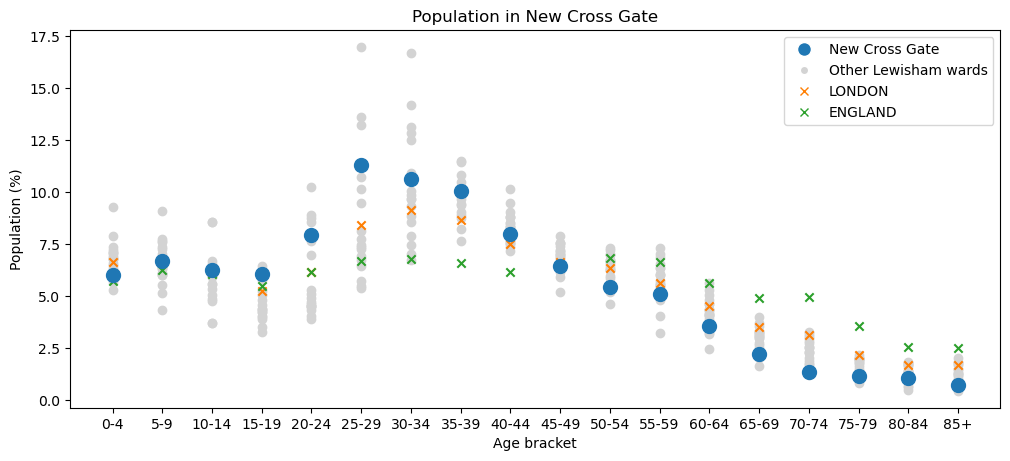

In [ ]:
plot_population('Population', pop_age_groups, ward, pop_all_refs)

Languages
==
Source: 2011 Census.

In [ ]:
summary_english_proficiency(english_proficiency, pop_totals, ward)


  English is the main language for 77.0% residents in New Cross Gate.

  Of the remaining residents, 18.8% can speak English well or very well.
  
  On the other hand, **4.3% of residents cannot speak English well or at all**,
  compared to a Lewisham average of 3.1%.
  
  This means an estimated 416 people in New Cross Gate may require everyday language support.
  

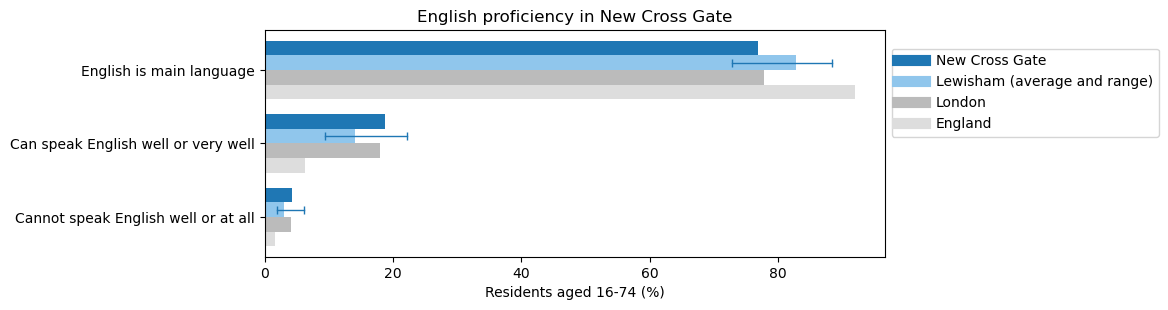

In [ ]:
plot_english_proficiency('English proficiency', english_proficiency, ward, english_proficiency_refs)

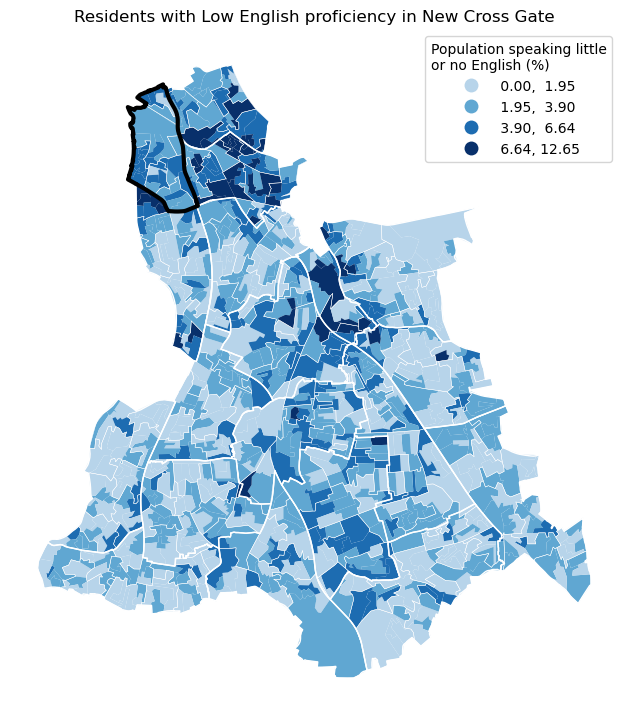

In [ ]:
map_low_english_proficiency('Residents with Low English proficiency', english_proficiency_oa, ward)

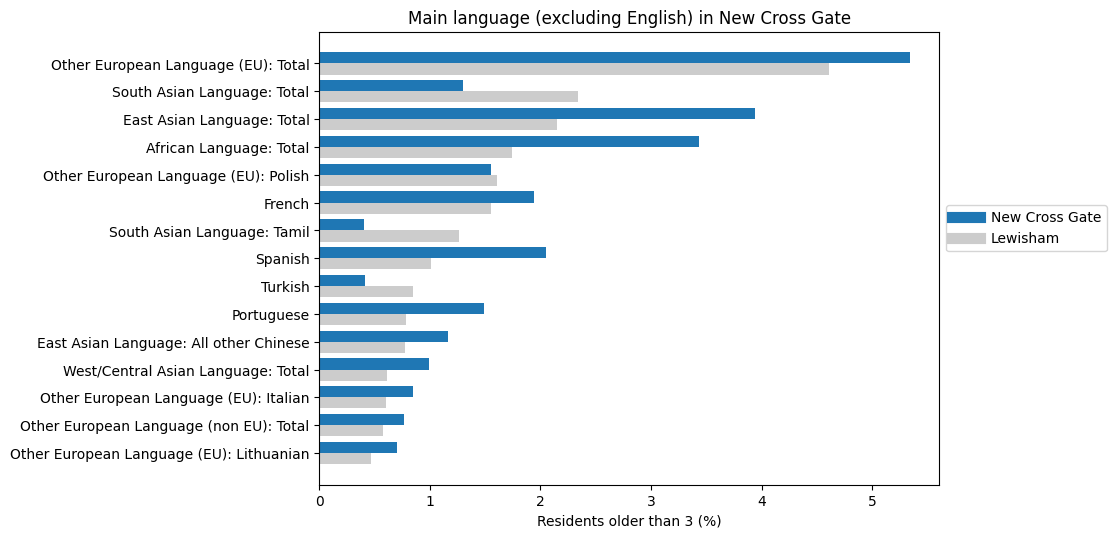

In [ ]:
plot_languages('Main language (excluding English)', main_language, ward, num_entries=15)

Employment
==
Source: 2011 Census.

In [ ]:
summary_econ_activity(econ_activity, ward)


  **The unemployment rate in New Cross Gate is 7.6%** among residents aged 16-74, 
  compared to a Lewisham average of 6.3%.
  
  26.4% of residents are not economically active, 
  for example because they are in education, looking after home or family, 
  long-term sick or disabled, or in retirement.
  

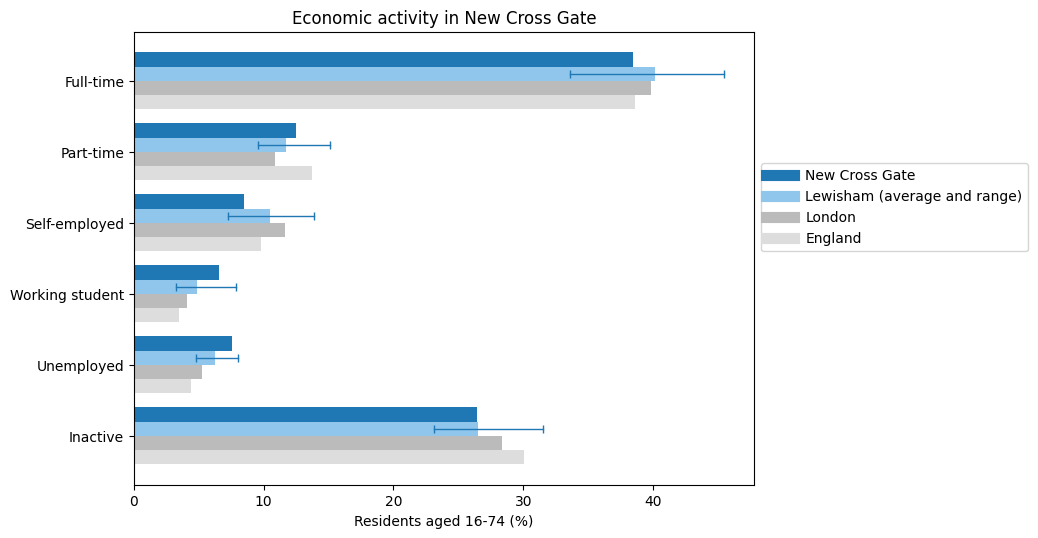

In [ ]:
plot_econ_activity('Economic activity', econ_activity, ward, econ_activity_refs)

Universal Credit
==
Source: DWP in August 2021

In [ ]:
summary_universal_credit(universal_credit, ward, 'August 2021')


  In New Cross Gate as of August 2021, 1,464 households were receiving Universal Credit.
  

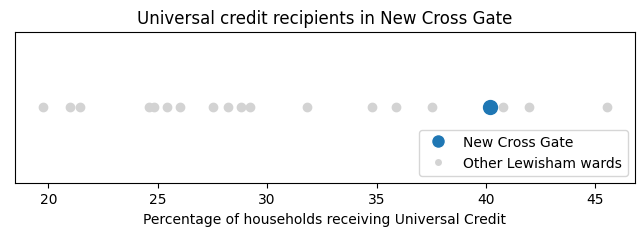

In [ ]:
plot_universal_credit(
    "Universal credit recipients", universal_credit[['Proportion of households receiving Universal Credit','Name']], ward
)

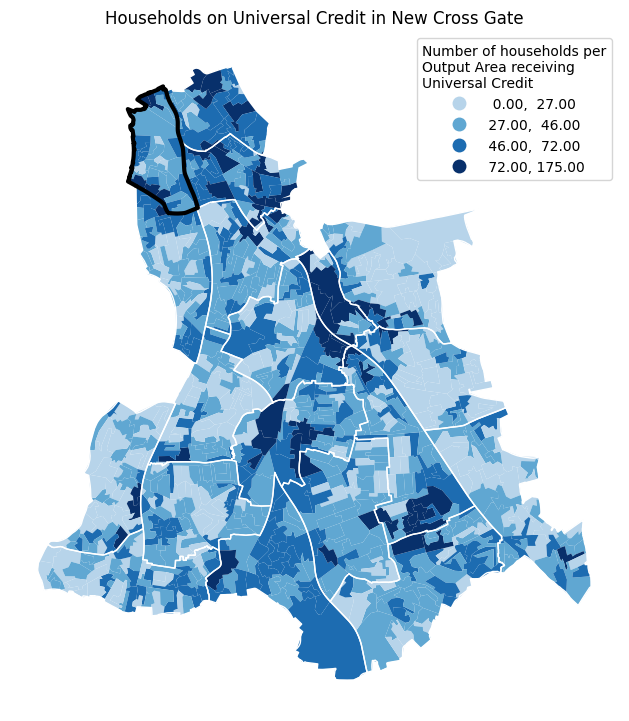

In [ ]:
map_universal_credit('Households on Universal Credit', universal_credit_oa, ward)

Deprivation
==
Source: 2019 Index of Multiple Deprivation. 

**IMPORTANT CAVEAT**: this data is only available at LSOA (2011) resolution, and does not always match the new ward boundaries very well. In such cases, we might over- or under-estimate the population of a ward by as much as 35%. In other words, we should treat these numbers as broad estimates until the new Census geographies are published in 2022.

In [ ]:
summary_imd(imd, ward)


  Of the 6 LSOAs in New Cross Gate, **2 rank in the bottom 20% of the country** (decile 1 or 2.)

  They are: Lewisham 001B, Lewisham 003A, Lewisham 003B, Lewisham 003C, Lewisham 003D, Lewisham 003E.
  

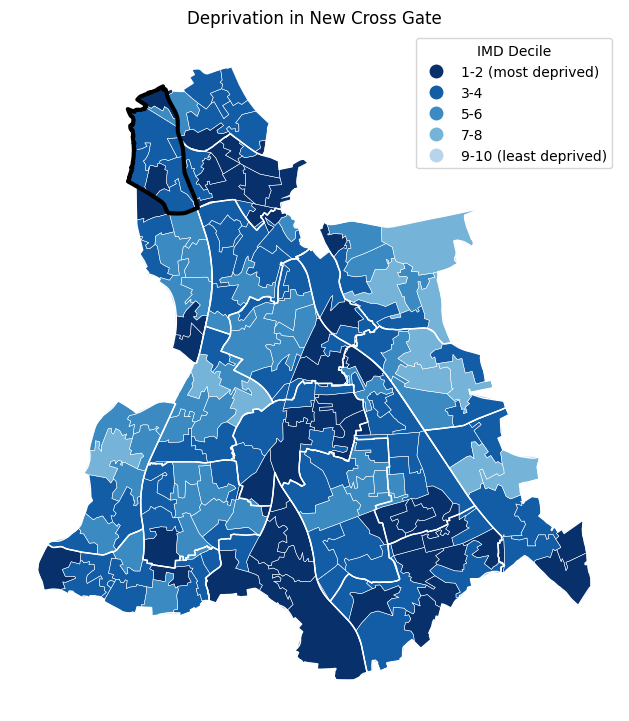

In [ ]:
map_imd('Deprivation', imd_lsoa, ward)

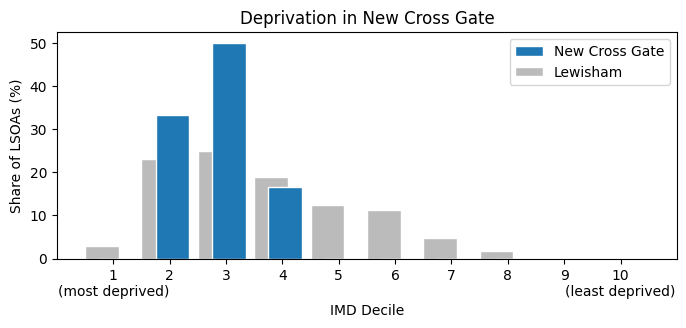

In [ ]:
plot_imd_share('Deprivation', imd, ward)

Educational attainment
==
Source: 2011 Census.

In [ ]:
summary_educational_attainment(educational_attainment_share, ward)


  There are [nine qualification levels](https://www.gov.uk/what-different-qualification-levels-mean/list-of-qualification-levels) in England: Entry level and then levels 1-9. 
  
  Levels 1-2 cover GCSE and equivalents, Level 3 covers A level and equivalents, and Levels 4-8 cover higher education equivalents.

  In New Cross Gate, 19% of residents have no qualifications; 11% have Level 1 qualifications; 12% have Level 2 qualifications; 1% have Apprenticeship; 12% have Level 3 qualifications; and 35% have Level 4 qualifications and above.
  

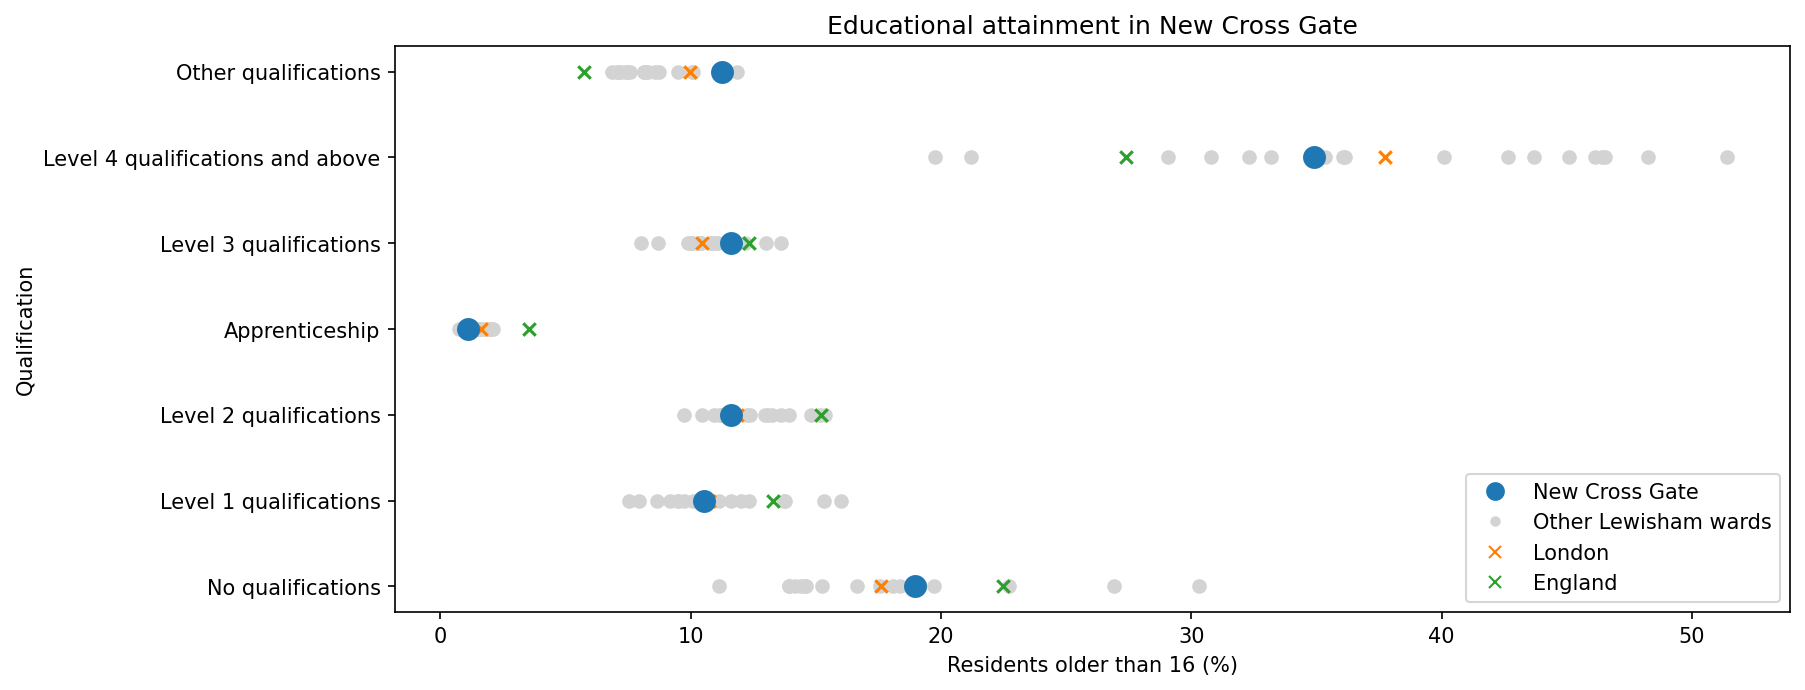

In [ ]:
plot_educational_attainment("Educational attainment", educational_attainment_share, ward, educational_attainment_refs_share)

Housing
==
Source: 2011 Census.

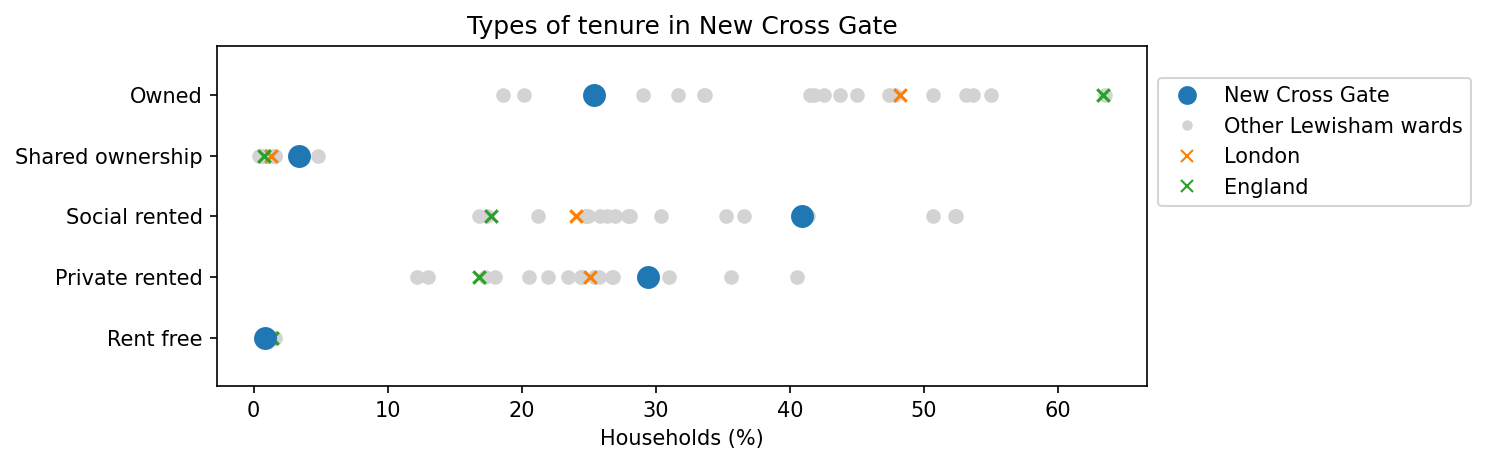

In [ ]:
plot_tenure_households_scatter('Types of tenure', tenure_households, ward, tenure_households_refs)
# plot_tenure_households_bar('Types of tenure', tenure_households, ward, tenure_households_refs)

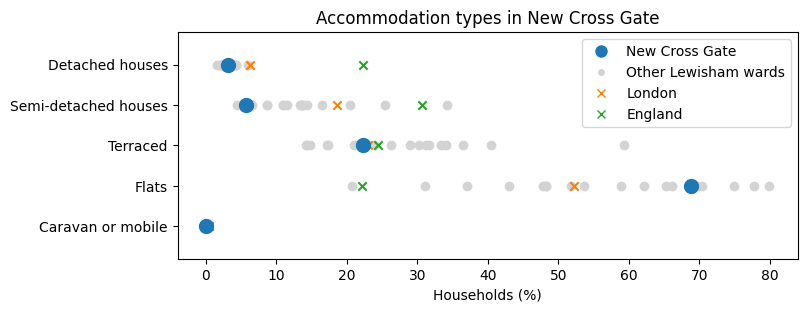

In [ ]:
plot_accommodation_type_scatter('Accommodation types', accommodation_type, ward, accommodation_type_refs)
# plot_accommodation_type_bar('Accommodation types', accommodation_type, ward, accommodation_type_refs)

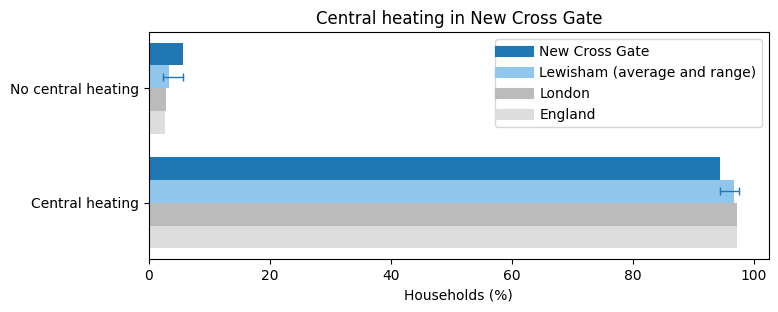

In [ ]:
# plot_central_heating_scatter('Central heating', central_heating, ward, central_heating_refs)
plot_central_heating_bar('Central heating', central_heating, ward, central_heating_refs)

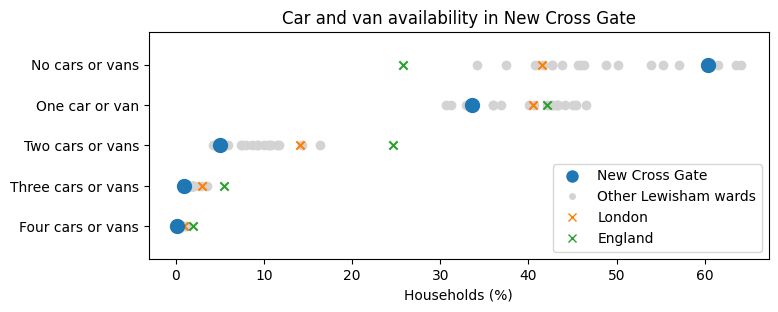

In [ ]:
plot_car_van_availability_scatter("Car and van availability", car_van_availability, ward, car_van_availability_refs)
# plot_car_van_availability_bar("Car and van availability", car_van_availability, ward, car_van_availability_refs)

Health
==
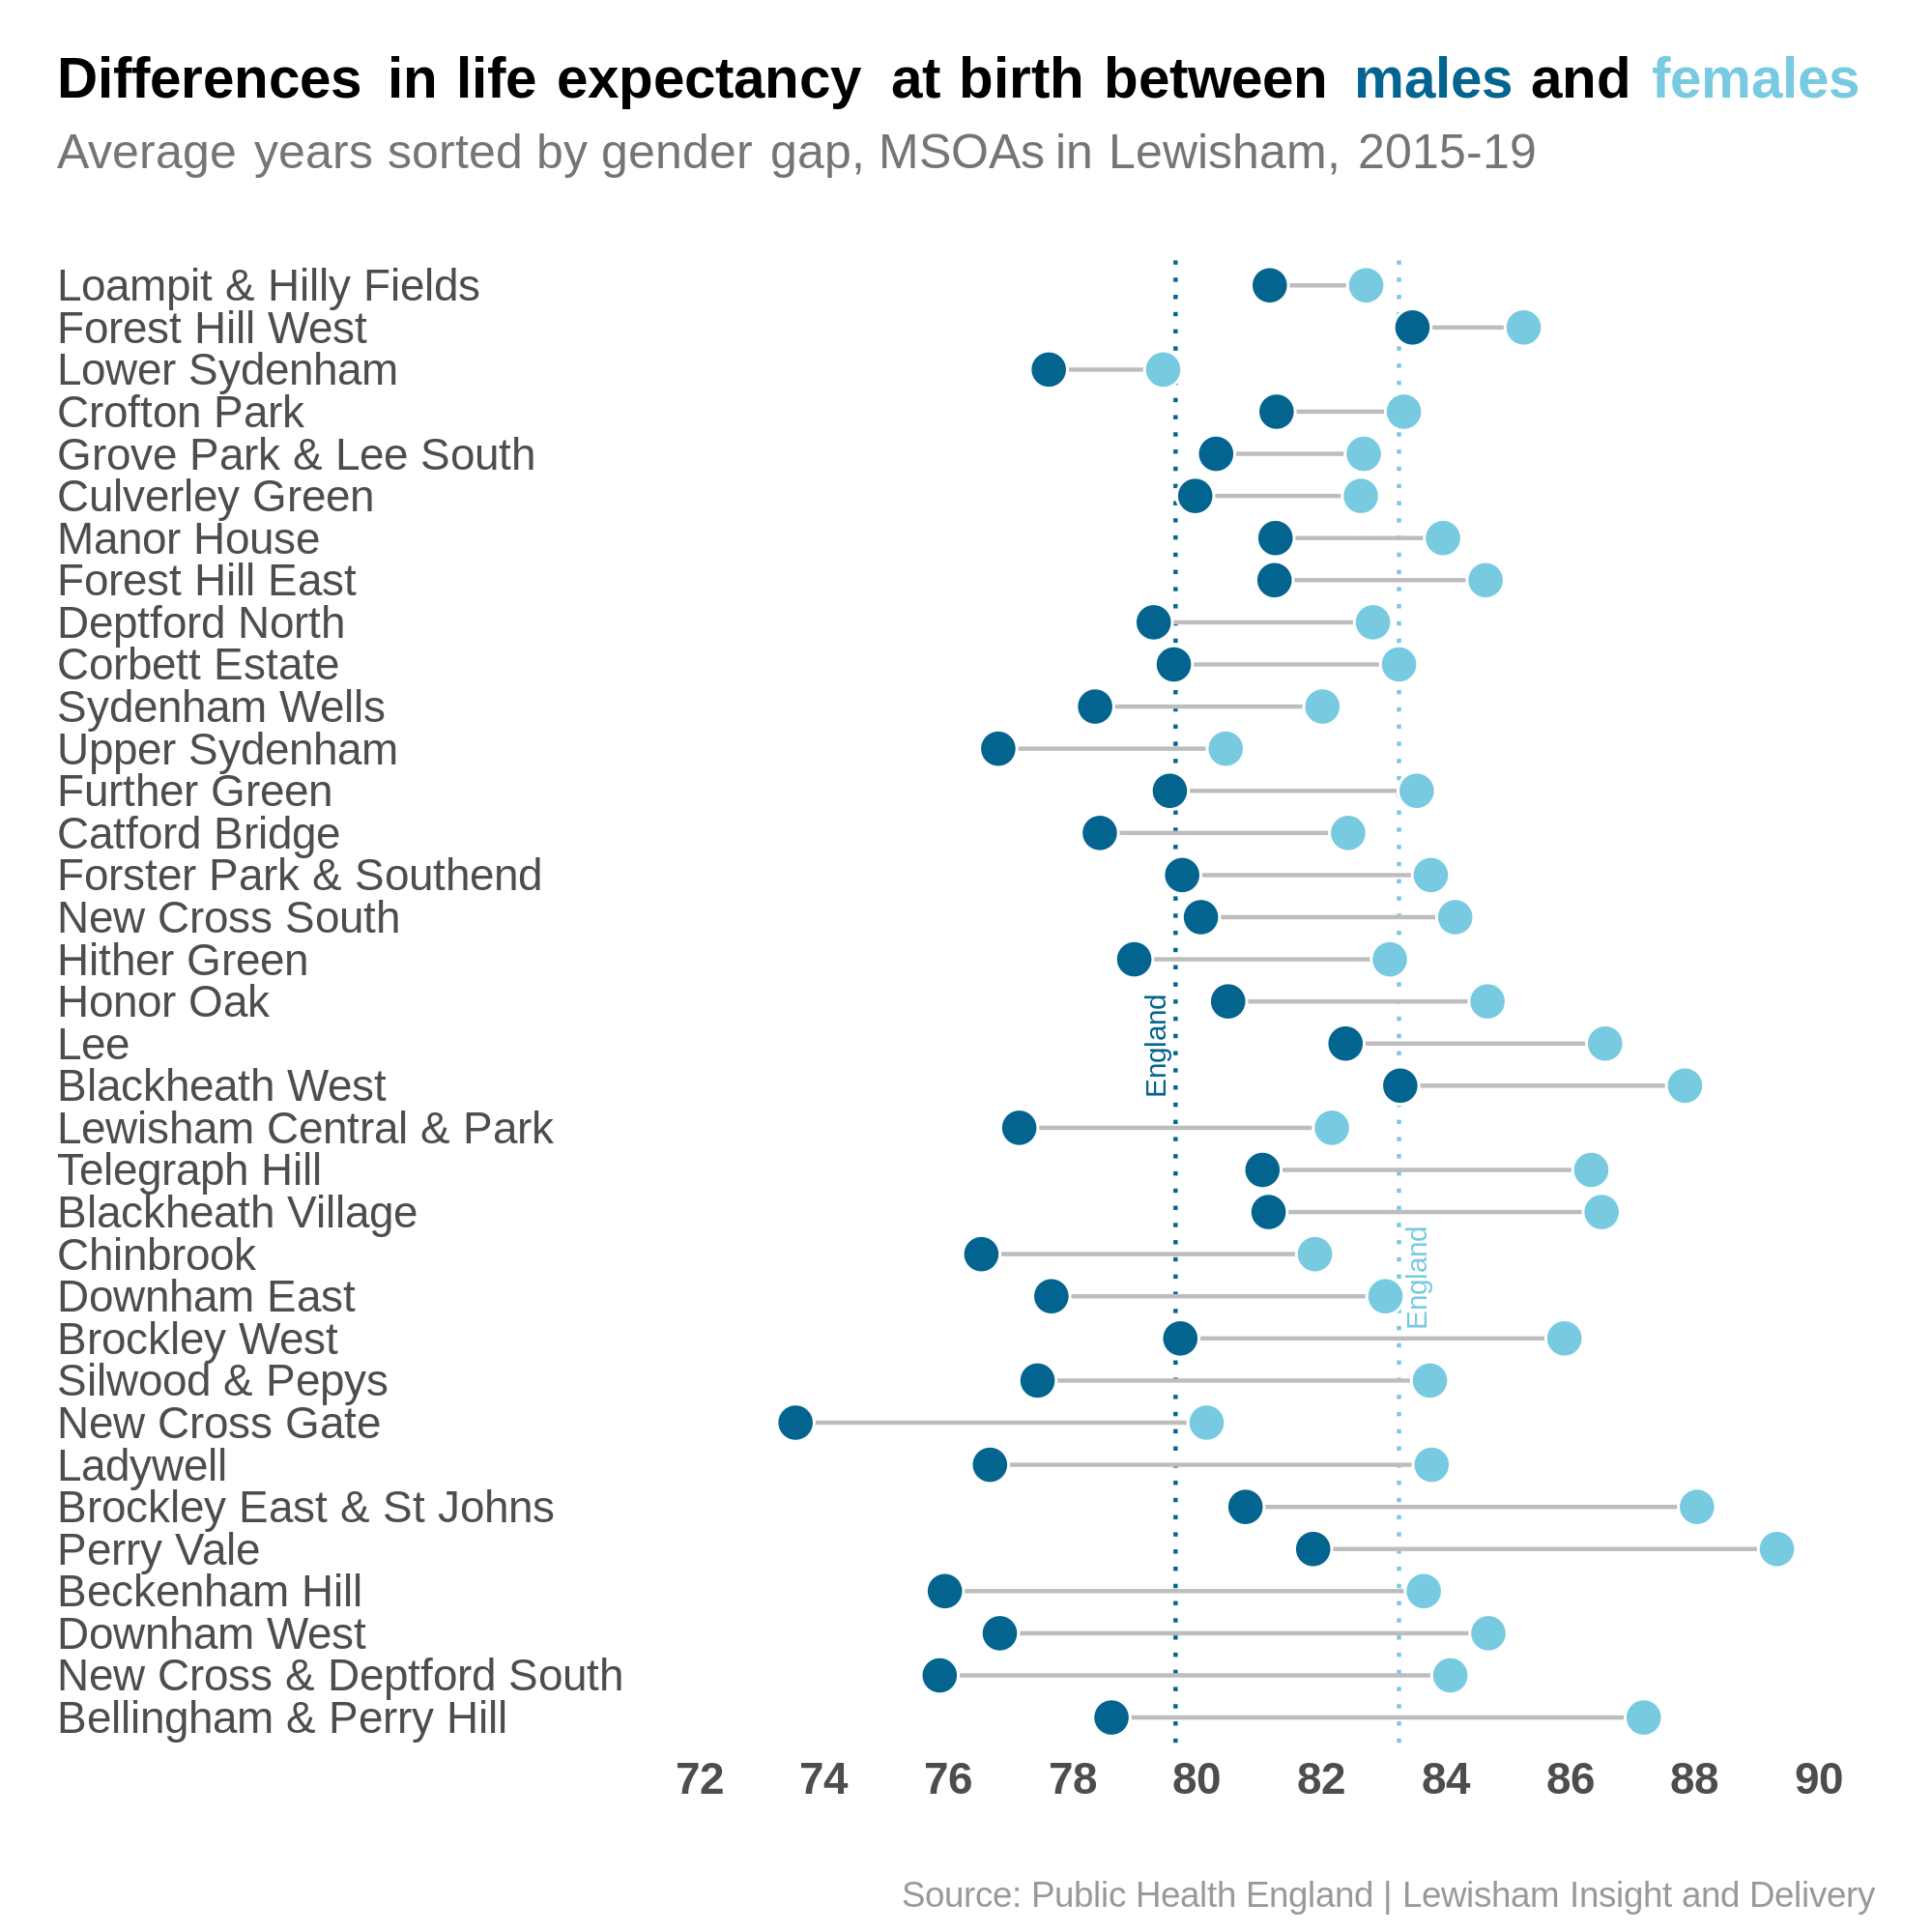

Life expectancy at birth 2015-2019 (5-year pooled data)

Data: Local Health | Public Health England, 2019
https://fingertips.phe.org.uk/profile/local-health
